<a href="https://www.kaggle.com/code/bryan194/molecular-translation?scriptVersionId=100951047" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### References:

- [starter notebook from Y. Nakama](https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter)
- [adapted notebook from Konrad](https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter)
- [PyTorch tutorial on image captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)
- [two-layer RNN implementation](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/pull/79)

In [1]:
import os
from matplotlib import pyplot as plt

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import pytorch_lightning as pl



import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CFG class now includes a new parameter: `decoder_layers`. For illustration purposes, I am running a two-layer LSTM for 1 epoch on 100k images.

In [2]:
print(timm.list_models(pretrained=True))

['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_224_in22k', 'beit_large_patch16_384', 'beit_large_patch16_512', 'botnet26t_256', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_small', 'convnext_tiny', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'crossvit_9_240', 'crossvit_9_dagger_240', 'crossvit_15_240', 'crossvi

In [3]:
#  n_channels_dict = {'efficientnet-b0': 1280, 'efficientnet-b1': 1280, 'efficientnet-b2': 1408,
#   'efficientnet-b3': 1536, 'efficientnet-b4': 1792, 'efficientnet-b5': 2048,
#   'efficientnet-b6': 2304, 'efficientnet-b7': 2560}

# This is not, to put it mildly, the most elegant solution ever - but I ran into some trouble 
# with checking the size of feature spaces programmatically inside the CFG definition.

class CFG:
    debug          = True
    apex           = False
    max_len        = 275
    print_freq     = 250
    num_workers    = 4
    num_pixels     = 9
#     model_name     = 'efficientnetv2_rw_m'
#     enc_size       = 2152
#     model_name     = 'efficientnetv2_rw_s'
#     enc_size       = 1792
    
    model_name     = 'efficientnet_b4'
    enc_size       = 1792
#     model_name     = 'mobilenetv2_100'
#     enc_size       = 1280
#     model_name     = 'resnet50'
#     enc_size       = 2048
#     model_name     = 'tnt_s_patch16_224'
#     enc_size       = 384
#     model_name     = 'vit_base_patch16_224'
#     enc_size       = 768
    samp_size      = 10000
    size           = 288
#     size           = 224
    scheduler      = 'CosineAnnealingLR' 
    epochs         = 20
    T_max          = 4  
    encoder_lr     = 1e-4
    decoder_lr     = 4e-4
    min_lr         = 1e-6
    batch_size     = 32
    weight_decay   = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm  = 10
    attention_dim  = 256
    embed_dim      = 512
    decoder_dim    = 512
    decoder_layers = 2     # number of LSTM layers
    dropout        = 0.5
    seed           = 42
    n_fold         = 5
    trn_fold       = 0 
    train          = True
    train_path     = '../input/bms-molecular-translation/'
    prep_path      = '../input/preprocessed-stuff/'
    prev_model     = './prp/muh_best.pth'

# Functions

In [4]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load(CFG.prep_path + 'tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

In [5]:
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred[:len(true)])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.seed)

In [6]:
# ====================================================
# Dataset
# ====================================================

class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        super().__init__()
        self.df         = df
        self.tokenizer  = tokenizer
        self.file_paths = df['file_path'].values
        self.labels     = df['InChI_text'].values
        self.transform  = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image = image)
            image     = augmented['image']
        label = self.labels[idx]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [7]:
def bms_collate(batch):
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first = True, padding_value = tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

In [8]:
####### CNN ENCODER

class Encoder(nn.Module):
    def __init__(self, model_name = CFG.model_name, pretrained = False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)

    def forward(self, x):
        bs       = x.size(0)
        features = self.cnn.forward_features(x)

        features = features.permute(0, 2, 3, 1)

        return features

The class `DecoderWithAttention` is updated to support a multi-layer LSTM.

In [9]:
####### RNN DECODER

# attention module
class Attention(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
# custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


# decoder
class DecoderWithAttention(nn.Module):
    '''
    Decoder network with attention network used for training
    '''

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, None

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
#         print(x.size())
        return x
    
class Transformer(pl.LightningModule):

    def __init__(self, 
                 len_vocab,
                 img_size=28, 
                 patch_size=7, 
                 in_chans=1, 
                 embed_dim=100, 
                 max_len=8, 
                 nhead=2, 
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                ):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        
        self.trg_emb = nn.Embedding(len_vocab, embed_dim)
        self.trg_pos_emb = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len

        self.transformer = torch.nn.Transformer(
            embed_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout
        )
        
        self.l = nn.LayerNorm(embed_dim)
        self.fc0 = nn.Linear(CFG.enc_size, embed_dim)
        self.fc = nn.Linear(embed_dim, len_vocab)

    def forward(self, images, captions):

        # embed images
        embed_imgs = self.patch_embed(images)
#         embed_imgs = self.fc0(images)
#         embed_imgs = embed_imgs.view(embed_imgs.size(0), -1, embed_imgs.size(1))
        
        embed_imgs = embed_imgs + self.pos_embed  
        # embed captions
        B, trg_seq_len = captions.shape
        trg_positions = (torch.arange(0, trg_seq_len).expand(B, trg_seq_len).to(self.device))
        embed_trg = self.trg_emb(captions) + self.trg_pos_emb(trg_positions)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(self.device)
        tgt_padding_mask = captions == 192
        # transformer
        y = self.transformer(
            embed_imgs.permute(1,0,2),  
            embed_trg.permute(1,0,2),  
            tgt_mask=trg_mask, 
            tgt_key_padding_mask = tgt_padding_mask
        ).permute(1,0,2) 
        # head

        pred = self.fc(self.l(y))
        
        return pred
    

    def predict(self, images, label_len=None):
        
        self.eval()
        with torch.no_grad():
            images = images.to(self.device)
            B = images.shape[0]
            eos = torch.tensor([190], dtype=torch.long, device=self.device).expand(B, 1)
            trg_input = eos
            
            if label_len is None: 
                max_len = self.max_len
            else:
                max_len = label_len
                
            for _ in range(max_len):
                preds = self(images, trg_input)
#                 print(trg_input[0])
#                 print('pred', preds[0, 0])
                preds_max = torch.argmax(preds, axis=2)
                # print(trg_input[0])
                # print(preds_max[0])
                # print('-----')
                
                trg_input = torch.cat([eos, preds_max], 1)
        
            return preds
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x, y[:,:-1])
        trg_output = y[:,1:] 
        loss = F.cross_entropy(y_hat.permute(0,2,1), trg_output) 
        # I know this is not the best metric...
        acc = (torch.argmax(y_hat, axis=2) == trg_output).sum().item() / (trg_output.shape[0]*trg_output.shape[1])
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [11]:
# Helper functions

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update(self, val, n=1):
        self.val    = val
        self.sum   += val * n
        self.count += n
        self.avg    = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s   = now - since
    es  = s / (percent)
    rs  = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, encoder, decoder, criterion, 
             encoder_optimizer, decoder_optimizer, epoch,
             encoder_scheduler, decoder_scheduler, device):
    
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    
    # switch to train mode
    encoder.train()
    decoder.train()
    
    start = end = time.time()
    global_step = 0
    
#     text_preds = []
    
    for step, (images, labels, label_lengths) in enumerate(train_loader):
        
        # measure data loading time
        data_time.update(time.time() - end)
        
        images        = images.to(device)
        labels        = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size    = images.size(0)
        
        
        features = encoder(images)
#         print(features.size())
#         asd
        
        label_lengths, sort_ind = label_lengths.squeeze(1).sort(dim=0, descending=True)
        features = features[sort_ind]
        caps_sorted = labels[sort_ind]
        decode_lengths = (label_lengths - 1).tolist()
        
#         caps_sorted1 = caps_sorted[:, :-1]
        predictions = decoder(features, caps_sorted)
                
        targets     = caps_sorted[:, 1:]

        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets     = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        loss        = criterion(predictions, targets)

        
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
            
        if CFG.apex:
            with amp.scale_loss(loss, decoder_optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
            
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), CFG.max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), CFG.max_grad_norm)
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            encoder_optimizer.step()
            decoder_optimizer.step()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            global_step += 1
            
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  #'Encoder LR: {encoder_lr:.6f}  '
                  #'Decoder LR: {decoder_lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), 
                   batch_time        = batch_time,
                   data_time         = data_time, 
                   loss              = losses,
                   remain            = timeSince(start, float(step+1)/len(train_loader)),
                   encoder_grad_norm = encoder_grad_norm,
                   decoder_grad_norm = decoder_grad_norm,
                   #encoder_lr=encoder_scheduler.get_lr()[0],
                   #decoder_lr=decoder_scheduler.get_lr()[0],
                   ))
                
    return losses.avg


def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device):
    
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    
    # switch to evaluation mode
    encoder.eval()
    decoder.eval()
    
    text_preds = []
    start = end = time.time()
    
    for step, (images, labels, label_lengths) in enumerate(valid_loader):
        
        # measure data loading time
        data_time.update(time.time() - end)
        
        images     = images.to(device)
        labels        = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size = images.size(0)
        
        with torch.no_grad():
            features    = encoder(images)
            
            label_lengths, sort_ind = label_lengths.squeeze(1).sort(dim=0, descending=True)
            features = features[sort_ind]
            caps_sorted = labels[sort_ind]
            decode_lengths = (label_lengths - 1).tolist()
                        
#             predictions = decoder.predict(features, CFG.max_len, tokenizer)

#             caps_sorted1 = caps_sorted[:, :-1]
            predictions = decoder(features, caps_sorted)
            # predictions = decoder.predict(features, labels.size(1)-1)

        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds        = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(
                   step, len(valid_loader), 
                   batch_time = batch_time,
                   data_time  = data_time,
                   remain     = timeSince(start, float(step+1)/len(valid_loader)),
                   ))
            
        targets = caps_sorted[:, 1:]     

        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets     = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss        = criterion(predictions, targets)
        losses.update(loss.item(), batch_size)
    
    text_preds = np.concatenate(text_preds)
    
    return losses.avg, text_preds

In [12]:
# ====================================================
# Train loop
# ====================================================
encoder = Encoder(CFG.model_name, pretrained = True)

# decoder = DecoderWithAttention(attention_dim = CFG.attention_dim, 
#                                embed_dim     = CFG.embed_dim, 
#                                encoder_dim   = CFG.enc_size,
#                                decoder_dim   = CFG.decoder_dim,
#                                num_layers    = CFG.decoder_layers,
#                                vocab_size    = len(tokenizer), 
#                                dropout       = CFG.dropout, 
#                                device        = device)

decoder = Transformer(
                 len_vocab=len(tokenizer.itos),
                 img_size=CFG.num_pixels, 
                 patch_size=2, 
                 in_chans=CFG.enc_size, 
                 embed_dim=512, 
                 max_len=275, 
                 nhead=8, 
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                )

def train_loop(folds, fold, encoder, decoder):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds  = folds.loc[trn_idx].reset_index(drop = True)
    valid_folds  = folds.loc[val_idx].reset_index(drop = True)
    valid_labels = valid_folds['InChI'].values

    train_dataset = TrainDataset(train_folds, tokenizer, transform = get_transforms(data = 'train'))
#     valid_dataset = TestDataset(valid_folds, transform = get_transforms(data = 'valid'))
    valid_dataset = TrainDataset(valid_folds, tokenizer, transform = get_transforms(data = 'valid'))


    
    train_loader = DataLoader(train_dataset, 
                              batch_size  = CFG.batch_size, 
                              shuffle     = True, 
                              num_workers = CFG.num_workers, 
                              pin_memory  = True,
                              drop_last   = True, 
                              collate_fn  = bms_collate)
#     valid_loader = DataLoader(valid_dataset, 
#                               batch_size  = CFG.batch_size, 
#                               shuffle     = False, 
#                               num_workers = CFG.num_workers,
#                               pin_memory  = True, 
#                               drop_last   = False)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size  = CFG.batch_size, 
                              shuffle     = False, 
                              num_workers = CFG.num_workers, 
                              pin_memory  = True,
                              drop_last   = False, 
                              collate_fn  = bms_collate)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, 
                                          mode     = 'min', 
                                          factor   = CFG.factor, 
                                          patience = CFG.patience, 
                                          verbose  = True, 
                                          eps      = CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, 
                                          T_max      = CFG.T_max, 
                                          eta_min    = CFG.min_lr, 
                                          last_epoch = -1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                                    T_0        = CFG.T_0, 
                                                    T_mult     = 1, 
                                                    eta_min    = CFG.min_lr, 
                                                    last_epoch = -1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================

#    states = torch.load(CFG.prev_model,  map_location=torch.device('cpu'))

#    encoder = Encoder(CFG.model_name, pretrained = True)
#    encoder.load_state_dict(states['encoder'])
    
    encoder.to(device)
    encoder_optimizer = Adam(encoder.parameters(), 
                             lr           = CFG.encoder_lr, 
                             weight_decay = CFG.weight_decay, 
                             amsgrad      = False)
#    encoder_optimizer.load_state_dict(states['encoder_optimizer'])
    encoder_scheduler = get_scheduler(encoder_optimizer)
#    encoder_scheduler.load_state_dict(states['encoder_scheduler'])
    
    
#    decoder.load_state_dict(states['decoder'])
    decoder.to(device)
    decoder_optimizer = Adam(decoder.parameters(), 
                             lr           = CFG.decoder_lr, 
                             weight_decay = CFG.weight_decay, 
                             amsgrad      = False)
#    decoder_optimizer.load_state_dict(states['decoder_optimizer'])

    decoder_scheduler = get_scheduler(decoder_optimizer)
 #   decoder_scheduler.load_state_dict(states['decoder_scheduler'])

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.stoi["<pad>"])

    best_score = np.inf
    best_loss  = np.inf
    record_score = []
    record_loss = []
    record_loss_val = []
    times = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, encoder, decoder, criterion, 
                            encoder_optimizer, decoder_optimizer, epoch, 
                            encoder_scheduler, decoder_scheduler, device)

        # eval
        avg_loss_val, text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device)
        text_preds = [f"InChI=1S/{text}" for text in text_preds]
        LOGGER.info(f"val labels: {valid_labels[:5]}")
        LOGGER.info(f"val preds: {text_preds[:5]}")
        
        # scoring
        score = get_score(valid_labels, text_preds)        
        
        if isinstance(encoder_scheduler, ReduceLROnPlateau):
            encoder_scheduler.step(score)
        elif isinstance(encoder_scheduler, CosineAnnealingLR):
            encoder_scheduler.step()
        elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
            encoder_scheduler.step()
            
        if isinstance(decoder_scheduler, ReduceLROnPlateau):
            decoder_scheduler.step(score)
        elif isinstance(decoder_scheduler, CosineAnnealingLR):
            decoder_scheduler.step()
        elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
            decoder_scheduler.step()

        elapsed = time.time() - start_time
        times.append(elapsed)

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - avg_val_loss: {avg_loss_val:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        record_score.append(round(score, 4))
        record_loss.append(round(avg_loss, 4))
        record_loss_val.append(round(avg_loss_val, 4))
        
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'encoder': encoder.state_dict(), 
                        'encoder_optimizer': encoder_optimizer.state_dict(), 
                        'encoder_scheduler': encoder_scheduler.state_dict(), 
                        'decoder': decoder.state_dict(), 
                        'decoder_optimizer': decoder_optimizer.state_dict(), 
                        'decoder_scheduler': decoder_scheduler.state_dict(), 
                        'text_preds': text_preds,
                       },
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
          
    print("train_loss=", record_loss)
    print("val_loss=", record_loss_val)
    print("val_score=", record_score)
    print('avg_time=', round(sum(times)/len(times)))

In [13]:
def get_train_file_path(image_id):

    return CFG.train_path + "train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

def get_test_file_path(image_id):

    return CFG.train_path + "test/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

In [14]:
# transformations

def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            HorizontalFlip(p=0.5),                  
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),   
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])


# Data

In [15]:
train = pd.read_pickle(CFG.prep_path + 'train2.pkl')

train['file_path'] = train['image_id'].apply(get_train_file_path)

print(f'train.shape: {train.shape}')

test = pd.read_csv('../input/bms-molecular-translation/sample_submission.csv')

test['file_path'] = test['image_id'].apply(get_test_file_path)

print(f'test.shape: {test.shape}')


if CFG.debug:
    # CFG.epochs = 1
    train = train.sample(n = CFG.samp_size, random_state = CFG.seed).reset_index(drop = True)

train.shape: (2424186, 6)
test.shape: (1616107, 3)


In [16]:
train_dataset = TrainDataset(train, tokenizer, transform = get_transforms(data='train'))

folds = train.copy()
Fold = StratifiedKFold(n_splits = CFG.n_fold, shuffle = True, random_state = CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

# Training

In [17]:
train_loop(folds, CFG.trn_fold, encoder, decoder)

========== fold: 0 training ==========


Epoch: [1][0/250] Data 1.583 (1.583) Elapsed 0m 3s (remain 13m 28s) Loss: 5.3429(5.3429) Encoder Grad: 0.5316  Decoder Grad: 8.1139  
Epoch: [1][249/250] Data 0.000 (0.007) Elapsed 2m 38s (remain 0m 0s) Loss: 1.6590(2.0921) Encoder Grad: 0.1119  Decoder Grad: 0.7770  
EVAL: [0/63] Data 0.826 (0.826) Elapsed 0m 1s (remain 1m 7s) 


val labels: ['InChI=1S/C21H26N2O4S/c1-27-19-12-10-17(11-13-19)16-22-21(24)15-18-7-5-6-14-23(18)28(25,26)20-8-3-2-4-9-20/h2-4,8-13,18H,5-7,14-16H2,1H3,(H,22,24)/t18-/m1/s1'
 'InChI=1S/C10H18O4/c1-2-3-4-5-6-7-8(11)9(12)10(13)14/h8,11H,2-7H2,1H3,(H,13,14)'
 'InChI=1S/C19H27N/c1-12-5-3-6-13(2)17(12)11-19(20)10-14-9-18(19)16-8-4-7-15(14)16/h3,5-6,14-16,18H,4,7-11,20H2,1-2H3'
 'InChI=1S/C16H20N4OS2/c1-20-15(12-8-22-13-5-3-2-4-11(12)13)18-19-16(20)23-9-14(21)17-10-6-7-10/h8,10H,2-7,9H2,1H3,(H,17,21)'
 'InChI=1S/C15H18ClN3O3S/c1-7-10-11(22-15(2,3)21-10)14(20-7)19-5-8(23-4)9-12(16)17-6-18-13(9)19/h5-7,10-11,14H,1-4H3/t7-,10-,11-,14-/m1/s1']
val preds: ['InChI=1S/C25H30N4O4/c1-3-26-2)28-28-25-21-21-21-28)28-28-28-28-24(28(28-30-28-28)28-28-30)28-28)30-3-3-3-3-3(3(27(3)30-3-3-3-3)19-19-19-3-13,13,13,13,13,24H24H,10-12-12-13H12H2,1-2H3,(H,,30,30,30,(19,,0/s1', 'InChI=1S/C27H30N4O4/c/c/c/c1-5-26(27-26-21(29-26-27-28(29-28-29-31-29-28)28-28-2)29-23)31(24(24-24-24(31-24-24)30-24-24-31)24)31)31)24)31)

EVAL: [62/63] Data 0.001 (0.018) Elapsed 0m 12s (remain 0m 0s) 


Epoch 1 - avg_train_loss: 2.0921  time: 172s
Epoch 1 - avg_val_loss: 1.5973
Epoch 1 - Score: 79.8835
Epoch 1 - Save Best Score: 79.8835 Model


Epoch: [2][0/250] Data 1.085 (1.085) Elapsed 0m 2s (remain 8m 34s) Loss: 1.6763(1.6763) Encoder Grad: 0.3300  Decoder Grad: 0.7904  
Epoch: [2][249/250] Data 0.000 (0.005) Elapsed 2m 37s (remain 0m 0s) Loss: 1.4206(1.5339) Encoder Grad: 0.2658  Decoder Grad: 0.8300  
EVAL: [0/63] Data 1.380 (1.380) Elapsed 0m 1s (remain 1m 44s) 


val labels: ['InChI=1S/C21H26N2O4S/c1-27-19-12-10-17(11-13-19)16-22-21(24)15-18-7-5-6-14-23(18)28(25,26)20-8-3-2-4-9-20/h2-4,8-13,18H,5-7,14-16H2,1H3,(H,22,24)/t18-/m1/s1'
 'InChI=1S/C10H18O4/c1-2-3-4-5-6-7-8(11)9(12)10(13)14/h8,11H,2-7H2,1H3,(H,13,14)'
 'InChI=1S/C19H27N/c1-12-5-3-6-13(2)17(12)11-19(20)10-14-9-18(19)16-8-4-7-15(14)16/h3,5-6,14-16,18H,4,7-11,20H2,1-2H3'
 'InChI=1S/C16H20N4OS2/c1-20-15(12-8-22-13-5-3-2-4-11(12)13)18-19-16(20)23-9-14(21)17-10-6-7-10/h8,10H,2-7,9H2,1H3,(H,17,21)'
 'InChI=1S/C15H18ClN3O3S/c1-7-10-11(22-15(2,3)21-10)14(20-7)19-5-8(23-4)9-12(16)17-6-18-13(9)19/h5-7,10-11,14H,1-4H3/t7-,10-,11-,14-/m1/s1']
val preds: ['InChI=1S/C25H31N4O2/c1-4-27(2)33-2-21-23-23-23-33)30-30-23-23-23(23(23-2-24(2)24-30-2)30-23)30-4-6-4-3-3(3)3-3)3-4-4-3)3/h5-7-20/h5-9,12,12,14,17,27H27H,14-14-17-17H17H2,1-2H3,(H,,33,34,33,(20-,0/s1', 'InChI=1S/C25H31N3O5/c/c/c/c1-4-6(23-21-23(2-27-30(30(30-30-30-33-33)33)33-33-33)33-23)35-23(23-23-23(35-23)23)35-23(6-33)6)33)35)4)36)5/h31(6-37)

EVAL: [62/63] Data 0.001 (0.026) Elapsed 0m 13s (remain 0m 0s) 


Epoch 2 - avg_train_loss: 1.5339  time: 171s
Epoch 2 - avg_val_loss: 1.4012
Epoch 2 - Score: 80.2545


Epoch: [3][0/250] Data 1.117 (1.117) Elapsed 0m 2s (remain 8m 52s) Loss: 1.3947(1.3947) Encoder Grad: 0.2241  Decoder Grad: 0.8664  
Epoch: [3][249/250] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 0s) Loss: 1.3212(1.3995) Encoder Grad: 0.1297  Decoder Grad: 0.8493  
EVAL: [0/63] Data 1.102 (1.102) Elapsed 0m 1s (remain 1m 24s) 


val labels: ['InChI=1S/C21H26N2O4S/c1-27-19-12-10-17(11-13-19)16-22-21(24)15-18-7-5-6-14-23(18)28(25,26)20-8-3-2-4-9-20/h2-4,8-13,18H,5-7,14-16H2,1H3,(H,22,24)/t18-/m1/s1'
 'InChI=1S/C10H18O4/c1-2-3-4-5-6-7-8(11)9(12)10(13)14/h8,11H,2-7H2,1H3,(H,13,14)'
 'InChI=1S/C19H27N/c1-12-5-3-6-13(2)17(12)11-19(20)10-14-9-18(19)16-8-4-7-15(14)16/h3,5-6,14-16,18H,4,7-11,20H2,1-2H3'
 'InChI=1S/C16H20N4OS2/c1-20-15(12-8-22-13-5-3-2-4-11(12)13)18-19-16(20)23-9-14(21)17-10-6-7-10/h8,10H,2-7,9H2,1H3,(H,17,21)'
 'InChI=1S/C15H18ClN3O3S/c1-7-10-11(22-15(2,3)21-10)14(20-7)19-5-8(23-4)9-12(16)17-6-18-13(9)19/h5-7,10-11,14H,1-4H3/t7-,10-,11-,14-/m1/s1']
val preds: ['InChI=1S/C31H34N6O2/c1-3-18(2)34-36-11-9-9-10-36)34-34-11-11-11(11(11(35-11(34)11)34(36)34)11)34-4-13-7-13-22(3)34-36)34-4-4-4-3-5-7-22/h3-5,8,12,15,15,19,29H,4,11-15-16,27,2,1-2H3,(H,,34,34,34,', 'InChI=1S/C31H34N3O5/c/c/c/c1-3-5(18-8-18(2-18-30(34-30(30-34-36-34)36)34-36(2)4-6)4(6(4-4-6(36-6)6)35-6(6(4)6)35)4)4)36)5)6(6)38)6)6)37)7-5-15-17-19,

EVAL: [62/63] Data 0.001 (0.021) Elapsed 0m 12s (remain 0m 0s) 


Epoch 3 - avg_train_loss: 1.3995  time: 172s
Epoch 3 - avg_val_loss: 1.3088
Epoch 3 - Score: 78.4855
Epoch 3 - Save Best Score: 78.4855 Model


Epoch: [4][0/250] Data 1.772 (1.772) Elapsed 0m 2s (remain 11m 4s) Loss: 1.3508(1.3508) Encoder Grad: 0.3401  Decoder Grad: 0.7101  


KeyboardInterrupt: 

In [22]:
# lstm
efficient_net_b1 = [98.8575, 73.6695, 72.2025, 75.6785, 72.8615, 73.5025, 67.227, 74.857, 65.8755, 63.5605, 62.218, 61.8435, 62.494, 62.4595, 60.855, 61.2445, 60.16, 59.3595, 58.445, 57.9975]
efficient_net_b1_loss = [2.3931803798675535, 1.628167809009552, 1.5203406267166137, 1.4713778057098388, 1.4598911304473876, 1.4517746849060058, 1.4298730211257935, 1.3751705694198608, 1.304869324684143, 1.237863293170929, 1.1833606758117676, 1.145661545753479, 1.1337855563163757, 1.132903272151947, 1.136840611934662, 1.1170298233032228, 1.099350608587265, 1.0599301619529724, 1.0109912855625152, 0.9796263043880462]

b2_train_score = [113.59625, 98.33, 96.615875, 94.968375, 94.140625, 94.623625, 93.863125, 92.865125, 91.84775, 91.042375]
efficient_net_b2 = [134.222, 74.5255, 80.9045, 76.0485, 74.751, 71.3455, 73.473, 66.329, 65.993, 64.856, 62.6475, 60.817, 61.522, 60.7185, 61.715, 61.191, 59.6985, 58.849, 59.1755, 56.8945]
efficient_net_b2_loss = [2.415083875179291, 1.6237234082221985, 1.5118725147247314, 1.4611049151420594, 1.4461445527076722, 1.4379349818229676, 1.409820526123047, 1.3576485114097596, 1.289951596736908, 1.2252001495361329, 1.1670255136489869, 1.1304647407531738, 1.1173807997703553, 1.1154722766876222, 1.1165171647071839, 1.1063506488800048, 1.0751800196170807, 1.0316696577072144, 0.9882933089733124, 0.9550682859420776]
b2_val_loss = [5.1344, 5.6729, 6.0253, 6.0020, 6.0312, 6.1491, 6.1898, 6.3044, 6.4776, 6.3926]
# 237s
lstm_b2_validation_score = [93.1755, 91.652, 93.192, 92.521, 93.373, 91.4925, 91.153, 87.3235, 88.247, 88.751]
lstm_b2_train_loss = [2.4151, 1.6237, 1.5119, 1.4611, 1.4461, 1.4379, 1.4098, 1.3576, 1.29, 1.2252]
lstm_b2_val_loss = [1.6287, 1.4787, 1.4049, 1.3824, 1.3779, 1.3586, 1.3113, 1.2794, 1.184, 1.1333]

efficient_net_b3 = [95.667, 83.3315, 76.262, 73.2065, 73.8655, 73.544, 67.0345, 68.6645, 67.535, 61.066, 62.0325, 59.302, 59.429, 58.9515, 60.4385, 62.1805, 60.259, 56.178, 55.834, 55.59]
efficient_net_b3_loss = [2.3996424560546874, 1.626395184993744, 1.5165460896492005, 1.465637098789215, 1.4504963603019714, 1.443153549194336, 1.4172072825431823, 1.359358612060547, 1.286353558063507, 1.2174233260154723, 1.1592508525848388, 1.1197750024795532, 1.107436776638031, 1.1040277109146117, 1.1063713212013244, 1.096435488462448, 1.0655429661273956, 1.018177206516266, 0.9751036190986633, 0.9428163130283356]
efficient_net_b4 = [250.2225, 229.892, 111.1725, 133.9945, 134.934, 146.641, 114.107, 81.764, 79.7775, 79.208, 80.16, 74.4985, 75.5305, 74.5765, 75.9875, 74.524, 74.388, 70.883, 72.6915, 68.602]
efficient_net_b4_loss = [3.1840683708190918, 2.869856611251831, 2.4396746187210083, 2.160268536567688, 2.102885934829712, 2.0599588737487795, 1.903951898097992, 1.718906756401062, 1.5983499155044556, 1.5180621557235718, 1.4636279873847962, 1.4322679510116578, 1.423622896194458, 1.41957506275177, 1.4109104981422425, 1.3853939290046693, 1.350641189098358, 1.3104349522590637, 1.2739801769256591, 1.2522076315879822]
efficient_net_b5 = [83.609, 74.229, 74.75, 76.512, 74.7315, 73.3395, 72.2375, 82.597, 83.251, 76.9785, 76.961, 75.74, 74.002, 75.263, 70.516, 72.561, 77.1875, 70.863, 75.4075, 74.069]
efficient_net_b5_loss = [2.0829786279201508, 1.557403645992279, 1.453078752040863, 1.401730174779892, 1.3860347771644592, 1.3810959169864654, 1.3654353585243224, 1.329354391336441, 1.2842514560222626, 1.2379606404304504, 1.194757817029953, 1.1652341079711914, 1.1550245118141174, 1.1558650314807892, 1.162438308238983, 1.1578786492347717, 1.1389484195709227, 1.1131686375141143, 1.0777646358013153, 1.0513258594274522]
efficient_net_b6 = [130.5265, 86.1965, 88.264, 88.764, 80.958, 85.9995, 90.244, 97.253, 78.8195, 79.524, 98.389, 92.6205, 93.9555, 90.7505, 81.7735, 80.19, 71.238, 74.874, 72.5205, 72.3895]
efficient_net_b6_loss = [2.0776397485733034, 1.5548398282527924, 1.4560341963768004, 1.4082622706890107, 1.3940581126213074, 1.3898768017292022, 1.3772511410713195, 1.3386958220005036, 1.2897724032402038, 1.2428567588329316, 1.2017232131958009, 1.1723768224716187, 1.1614158926010132, 1.1626962089538575, 1.1686801233291626, 1.1650111904144287, 1.1489011342525481, 1.1179789177179336, 1.0860439949035645, 1.0597657492160797]

mobile_net = [255.6650, 78.9660, 70.1145, 77.7875, 74.6280, 71.4225, 73.6685, 70.1670, 71.3795, 74.1130]
tnt = [98.3080, 88.8265, 79.2645, 70.0020, 72.5620, 71.3095, 70.1475, 78.2650, 69.4255, 69.5965]
vit = [108.6810, 74.8460, 72.3420, 76.8190, 70.9615, 70.2555, 69.4180, 72.0445, 71.0110, 69.7120]
resnet50 = [164.9995, 100.7000, 83.7735, 70.8685, 70.8185, 70.9180, 70.0885, 73.7620, 70.0250, 71.5485]

# 100000
train_losses = [1.3926620348930359, 0.9320967340946198, 0.7832191390752792, 0.7080147546768188, 0.6866521205425262, 0.6801256247997284, 0.6680761493682862, 0.6320035829424858, 0.5764910193800926, 0.5121954302072526]
val_loss = [5.8059, 5.5785, 5.6106, 5.5010, 5.4806, 5.4974, 5.4568, 5.3981, 5.1789, 4.9673]
validation_scores = [58.73845, 53.42155, 49.25315, 47.46995, 46.9863, 46.3712, 45.1068, 42.47475, 39.59625, 36.06345]

In [28]:
# transformer
b1_train_loss= [2.0254, 1.5208, 1.3879, 1.3119, 1.2876, 1.2845, 1.2807, 1.2471, 1.1961, 1.1336, 1.0728, 1.0251, 1.0067, 1.0105, 1.0312, 1.0462, 1.034, 0.9965, 0.9411, 0.8954]
b1_val_loss= [1.5912, 1.4007, 1.3067, 1.2555, 1.2478, 1.2322, 1.2152, 1.1691, 1.1226, 1.0852, 1.0429, 1.0146, 1.0113, 1.0089, 1.0152, 1.0267, 1.0075, 0.9829, 0.9551, 0.9325]
b1_val_score= [81.0115, 77.368, 78.5905, 77.892, 77.9605, 78.146, 76.8335, 77.413, 76.2165, 76.5495, 75.9055, 76.2805, 76.0995, 76.2025, 76.0005, 76.866, 75.6845, 75.9935, 75.853, 76.084]
avg_time= 119

b2_train_loss= [2.0542, 1.5482, 1.4111, 1.3417, 1.3175, 1.3121, 1.3036, 1.2721, 1.2211, 1.1627, 1.1049, 1.0605, 1.0455, 1.0483, 1.0673, 1.0763, 1.0596, 1.0233, 0.9713, 0.927]
b2_val_loss= [1.6249, 1.4308, 1.3311, 1.2844, 1.2798, 1.2615, 1.2346, 1.2079, 1.1628, 1.1099, 1.0809, 1.0552, 1.0511, 1.0461, 1.0533, 1.0511, 1.0464, 1.0178, 0.9866, 0.9651]
b2_val_score= [79.9055, 77.8795, 76.7025, 77.1645, 77.006, 77.026, 77.2775, 76.404, 76.7725, 76.649, 76.555, 75.8995, 75.9365, 75.936, 75.7765, 75.581, 76.7515, 76.55, 75.8495, 75.7135]
avg_time= 117

b3_train_loss= [2.0776, 1.5558, 1.4224, 1.3509, 1.3286, 1.3268, 1.3225, 1.2956, 1.2434, 1.1775, 1.1094, 1.0585, 1.0391, 1.0432, 1.0624, 1.0732, 1.0627, 1.025, 0.9763, 0.9271]
b3_val_loss= [1.6118, 1.4392, 1.3392, 1.2936, 1.2893, 1.275, 1.2619, 1.2197, 1.1818, 1.1245, 1.0765, 1.0389, 1.0356, 1.0315, 1.0439, 1.0419, 1.0399, 1.009, 0.9806, 0.9576]
b3_val_score= [81.0525, 78.7755, 78.1165, 78.244, 78.1785, 78.285, 78.1685, 77.7865, 77.7, 77.6885, 76.8675, 76.837, 76.521, 76.8535, 76.6015, 76.619, 76.3585, 76.356, 76.056, 76.212]
avg_time= 138

#eff v2
v2s_train_loss= [2.0769, 1.5393, 1.406, 1.3359, 1.3119, 1.3116, 1.3081, 1.2763, 1.2255, 1.1656, 1.1037, 1.0582, 1.0401, 1.0438, 1.065, 1.0824, 1.066, 1.0291, 0.9781, 0.9312]
v2s_val_loss= [1.5943, 1.4236, 1.3318, 1.2792, 1.2756, 1.2609, 1.2407, 1.1987, 1.158, 1.1299, 1.0778, 1.0514, 1.0456, 1.0427, 1.0563, 1.0695, 1.0531, 1.03, 1.0011, 0.9761]
v2s_val_score= [77.75, 78.7015, 79.808, 77.921, 78.1235, 77.982, 78.087, 77.7065, 76.135, 77.065, 77.181, 76.345, 76.3445, 76.3855, 76.771, 76.964, 76.555, 76.802, 76.593, 76.468]
avg_time= 154

mb_train_loss= [2.1395, 1.5894, 1.4561, 1.3845, 1.3648, 1.3615, 1.3536, 1.3188, 1.2604, 1.1957, 1.1333, 1.0862, 1.0693, 1.0737, 1.0905, 1.1011, 1.0888, 1.0493, 1.0024, 0.958]
mb_val_loss= [1.6516, 1.4603, 1.3635, 1.3242, 1.3187, 1.3028, 1.2751, 1.2422, 1.2008, 1.1358, 1.0972, 1.0721, 1.063, 1.0637, 1.0703, 1.0738, 1.0695, 1.0344, 1.0156, 0.9872]
mb_val_score= [79.784, 77.7465, 77.7155, 78.1355, 77.8515, 77.7705, 77.9695, 76.4995, 76.466, 76.927, 76.69, 76.496, 76.383, 76.7715, 76.1235, 76.082, 76.582, 76.512, 76.191, 75.964]
avg_time= 84

tnt_train_loss= [2.0973, 1.5649, 1.4287, 1.3537, 1.3316, 1.3277, 1.315, 1.28, 1.2238, 1.1653, 1.105, 1.0587, 1.0419, 1.0456, 1.063, 1.0739, 1.0584, 1.0221, 0.9724, 0.929]
tnt_val_loss= [1.6222, 1.4319, 1.3413, 1.2951, 1.291, 1.2715, 1.2408, 1.1993, 1.1542, 1.1109, 1.068, 1.0501, 1.0456, 1.0428, 1.049, 1.0507, 1.0401, 1.0227, 0.9981, 0.9747]
tnt_val_score= [78.394, 77.8585, 78.5445, 78.293, 78.109, 78.3185, 77.9995, 77.1255, 76.2825, 76.641, 76.128, 76.2895, 76.1485, 75.8915, 76.837, 76.225, 75.852, 75.9005, 76.1415, 76.0545]
avg_time= 192

vit_train_loss= [2.1088, 1.5578, 1.4232, 1.3552, 1.335, 1.3325, 1.3233, 1.2908, 1.235, 1.1679, 1.1047, 1.0567, 1.0393, 1.042, 1.0587, 1.0682, 1.0526, 1.0158, 0.9676, 0.9227]
vit_val_loss= [1.6403, 1.4335, 1.343, 1.3024, 1.2966, 1.2813, 1.2538, 1.2199, 1.1676, 1.1195, 1.0785, 1.0466, 1.042, 1.0382, 1.0468, 1.043, 1.0272, 1.0087, 0.9825, 0.9646]
vit_val_score= [78.1375, 78.4565, 78.4075, 78.0135, 78.1905, 78.471, 77.111, 76.575, 76.902, 75.8885, 76.4675, 76.378, 76.157, 76.2235, 76.46, 76.378, 76.598, 76.274, 75.7245, 75.9145]
avg_time= 184

res_train_loss= [2.1231, 1.5809, 1.451, 1.3891, 1.3699, 1.3682, 1.3636, 1.3236, 1.2602, 1.1927, 1.1336, 1.087, 1.0703, 1.074, 1.0924, 1.1006, 1.0898, 1.05, 1.0006, 0.9565]
res_val_loss= [1.639, 1.4486, 1.3774, 1.3388, 1.33, 1.3216, 1.2876, 1.244, 1.1962, 1.1439, 1.1002, 1.0725, 1.0691, 1.0666, 1.0766, 1.0748, 1.0714, 1.0455, 1.0159, 0.9956]
res_val_score= [78.675, 78.3835, 79.0965, 78.173, 77.821, 77.384, 78.321, 77.678, 76.862, 76.855, 76.0685, 76.8305, 76.589, 76.609, 76.384, 76.414, 76.3755, 76.9235, 76.5935, 76.387]
avg_time= 121

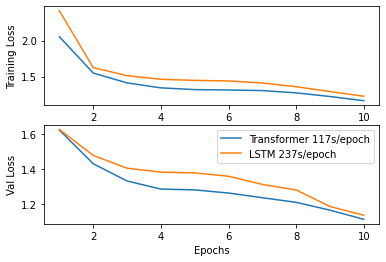

In [53]:
x = range(1, 11)
plt.figure()
plt.subplot(211)
plt.plot(x, b2_train_loss[:10])
plt.plot(x, lstm_b2_train_loss)
plt.ylabel("Training Loss")
plt.subplot(212)
plt.plot(x, b2_val_loss[:10])
plt.plot(x, lstm_b2_val_loss)
plt.ylabel("Val Loss")
plt.xlabel("Epochs")
# plt.ylim(0.8, 1.4)
plt.xticks(range(2,12,2))
plt.legend(['Transformer 117s/epoch', 'LSTM 237s/epoch'])
plt.savefig("fig0.jpg", dpi=200)
plt.show()

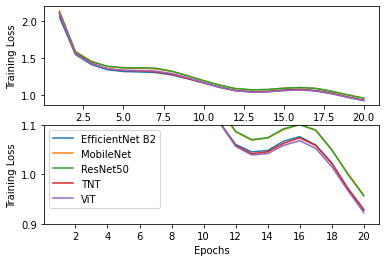

In [51]:
x = range(1, 21)
plt.figure()
plt.subplot(211)
plt.plot(x, b2_train_loss)
plt.plot(x, mb_train_loss)
plt.plot(x, res_train_loss)
plt.plot(x, tnt_train_loss)
plt.plot(x, vit_train_loss)
plt.ylabel("Training Loss")

plt.subplot(212)
plt.plot(x, b2_train_loss)
plt.plot(x, mb_train_loss)
plt.plot(x, res_train_loss)
plt.plot(x, tnt_train_loss)
plt.plot(x, vit_train_loss)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")
plt.ylim(0.9, 1.1)
plt.xticks(range(2,22,2))
plt.legend(['EfficientNet B2', 'MobileNet', 'ResNet50', 'TNT', 'ViT'])
plt.savefig("fig1.jpg", dpi=200)
plt.show()

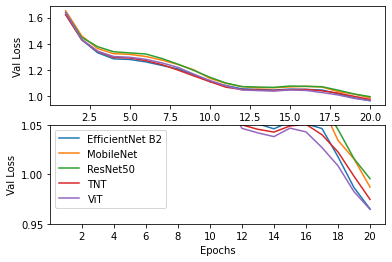

In [52]:
# x = range(1, 21)
# plt.figure()
# plt.plot(x, b2_val_loss)
# plt.plot(x, mb_val_loss)
# plt.plot(x, res_val_loss)
# plt.plot(x, tnt_val_loss)
# plt.plot(x, vit_val_loss)
# plt.plot(x, v2s_val_loss)
# plt.ylabel("Validation Loss")
# plt.xlabel("Epochs")
# plt.ylim(0.95, 1.1)
# plt.xticks(range(2,22,2))
# plt.legend(['EfficientNet B2', 'MobileNet', 'ResNet50', 'TNT', 'ViT', 'EfficientNetV2-S'])
# plt.savefig("fig2.jpg", dpi=200)
# plt.show()

x = range(1, 21)
plt.figure()
plt.subplot(211)
plt.plot(x, b2_val_loss)
plt.plot(x, mb_val_loss)
plt.plot(x, res_val_loss)
plt.plot(x, tnt_val_loss)
plt.plot(x, vit_val_loss)
plt.ylabel("Val Loss")

plt.subplot(212)
plt.plot(x, b2_val_loss)
plt.plot(x, mb_val_loss)
plt.plot(x, res_val_loss)
plt.plot(x, tnt_val_loss)
plt.plot(x, vit_val_loss)
plt.ylabel("Val Loss")
plt.xlabel("Epochs")
plt.ylim(0.95, 1.05)
plt.xticks(range(2,22,2))
plt.legend(['EfficientNet B2', 'MobileNet', 'ResNet50', 'TNT', 'ViT'])
plt.savefig("fig2.jpg", dpi=200)
plt.show()

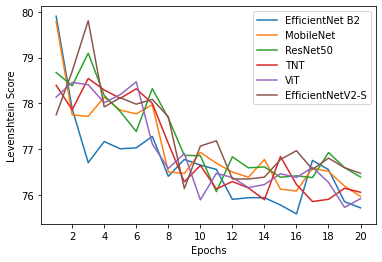

In [38]:
x = range(1, 21)
plt.figure()
plt.plot(x, b2_val_score)
plt.plot(x, mb_val_score)
plt.plot(x, res_val_score)
plt.plot(x, tnt_val_score)
plt.plot(x, vit_val_score)
plt.plot(x, v2s_val_score)
plt.ylabel("Levenshtein Score")
plt.xlabel("Epochs")
# plt.ylim(50, 100)
plt.xticks(range(2,22,2))
plt.legend(['EfficientNet B2', 'MobileNet', 'ResNet50', 'TNT', 'ViT', 'EfficientNetV2-S'])
plt.savefig("fig3.jpg", dpi=200)
plt.show()

# Submission (do not run the cells below)

In [ ]:
# def inference(test_loader, encoder, decoder, tokenizer, device):
    
#     encoder.eval()
#     decoder.eval()
    
#     text_preds = []
#     tk0 = tqdm(test_loader, total = len(test_loader))
    
#     for images in tk0:
        
#         images = images.to(device)
        
#         with torch.no_grad():
#             features = encoder(images)
#             predictions = decoder.predict(features, CFG.max_len, tokenizer)
            
#         predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
#         _text_preds = tokenizer.predict_captions(predicted_sequence)
#         text_preds.append(_text_preds)
        
#     text_preds = np.concatenate(text_preds)
    
#     return text_preds

In [ ]:
# ====================================================
# inference
# ====================================================

# test_dataset = TestDataset(test, transform = get_transforms(data = 'valid'))
# test_loader  = DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = CFG.num_workers)
# predictions  = inference(test_loader, encoder, decoder, tokenizer, device)

In [ ]:
# ====================================================
#  submission
# ====================================================

# test['InChI'] = [f"InChI=1S/{text}" for text in predictions]
# test[['image_id', 'InChI']].to_csv('submission.csv', index=False)